In [ ]:
!pip install  torchtoolbox #efficientnet_pytorch

In [ ]:
import torch
import torchvision
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
# from efficientnet_pytorch import EfficientNet
%matplotlib inline

# 1 PyTorch Dataset and DataLoader [this kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader/data)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

In [ ]:
print(torch.__version__)

1.7.0+cu101


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Считать данные

## 1 Custom Dataset

you have to overwrite **__len__()** and **__getitem__()** functions.

official code : 

```python
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __init__(self, files):
        raise NotImplementedError

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```

- **__init__()** : initial processes like reading a csv file, assigning transforms, ... 
- **__len__()** : return the size of input data
- **__getitem__()** : return data and label at orbitary index

In [ ]:
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Отобразить картинку

(28, 28)


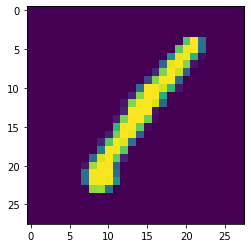

1

42000

let's create dataset for loading handwritten-digits data

In [ ]:
train_dataset = DatasetMNIST(path, transform=None)

## 2 transform is None

In [ ]:
# we can access and get data with index by __getitem__(index)


we now didn't convert numpy array.

In [ ]:
print(img.shape)
print(type(img))

(1, 28, 28)
<class 'numpy.ndarray'>


## 3 take a look at the dataset

you have to use data loader in PyTorch that will accutually read the data within batch size and put into memory.

we can use dataloader as iterator by using iter() function.

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


we can look at images and labels of batch size by extracting data .next() method.

In [ ]:


print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


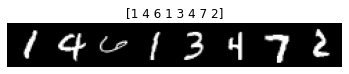

In [ ]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

## 4 transform it ToTensor()**

In [ ]:
train_dataset2 = DatasetMNIST2

In [ ]:


print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [ ]:


print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


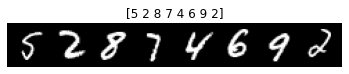

In [ ]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

## 5 transform it [ToTensor(), some [augmentations](https://pytorch.org/docs/stable/torchvision/transforms.html)]

transforms.* methods use some type of input data like (tensor only), (tensor or numpy), (PILimage only), so you have to consider the order of transform

**ToTensor()**

```python
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    (this is only for np.uint8 type)
    """
```

ToTensor() takes **PIL image** or **numpy ndarray** (both shapes are (Height, Width, Channels))

**ToPILImage**

```python
    """Convert a tensor or an ndarray to PIL Image.
    Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape
    H x W x C to a PIL Image while preserving the value range.
    Args:
        mode (`PIL.Image mode`_): color space and pixel depth of input data (optional).
            If ``mode`` is ``None`` (default) there are some assumptions made about the input data:
            1. If the input has 3 channels, the ``mode`` is assumed to be ``RGB``.
            2. If the input has 4 channels, the ``mode`` is assumed to be ``RGBA``.
            3. If the input has 1 channel, the ``mode`` is determined by the data type (i,e,
            ``int``, ``float``, ``short``).
    .. _PIL.Image mode: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#concept-modes
    """
```

ToPILImage() takes **torch.*Tensor ( C, H, W )** or **numpy ndarray ( H, W, C )**

**RandomHorizontalFlip**

```python
    """Horizontally flip the given PIL Image randomly with a given probability.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """
```

RandomHorizontalFlip() takes **PIL Image** only

if you want to take data augmentation, you have to make List using **torchvision.transforms.Compose**

this function can convert some image by order within **\__call__** method.

```python
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```

In [ ]:


print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


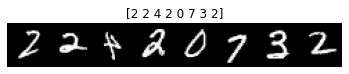

In [ ]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

# 2 Melanoma classification

In [ ]:
!ls ./gdrive/My\ Drive/Colab\ Notebooks/Семинар\ 10

archive_1.zip  digits.zip	 melanoma_pytorch_practice.ipynb
archive_2.zip  main.py		 pytorch-dataset-and-dataloader.ipynb
archive.zip    melanoma_1.ipynb
data	       melanoma.ipynb


In [ ]:
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(47)

In [ ]:
device = 

## 2.1 Посмотрим на данные

In [ ]:
train_df = 
test_df = 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


<bound method DataFrame.info of          image_name  patient_id  ...  site_upper extremity  site_nan
0      ISIC_0052060  IP_3579794  ...                     0         1
1      ISIC_0052349  IP_7782715  ...                     0         0
2      ISIC_0058510  IP_7960270  ...                     0         0
3      ISIC_0073313  IP_6375035  ...                     0         0
4      ISIC_0073502  IP_0589375  ...                     0         0
...             ...         ...  ...                   ...       ...
10977  ISIC_9992485  IP_4152479  ...                     0         0
10978  ISIC_9996992  IP_4890115  ...                     0         0
10979  ISIC_9997917  IP_2852390  ...                     1         0
10980  ISIC_9998234  IP_8861963  ...                     0         0
10981  ISIC_9999302  IP_6214039  ...                     1         0

[10982 rows x 14 columns]>

In [ ]:
train_images = "./gdrive/My Drive/Colab Notebooks/Семинар 10/data/train"
test_images = "./gdrive/My Drive/Colab Notebooks/Семинар 10/data/test"

In [ ]:
im_path = 

In [ ]:
im_path

'./gdrive/My Drive/Colab Notebooks/Семинар 10/data/train/ISIC_2637011.jpg'

In [ ]:
x = cv2.imread(im_path)


In [ ]:
x

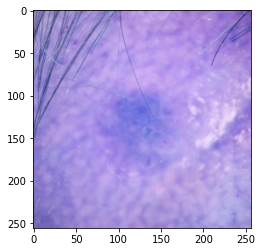

## 2.2 Предобработка Meta данных

In [ ]:
# One-hot encoding of anatom_site_general_challenge feature


# Sex features


# Age features


# fill nan


In [ ]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

['sex',
 'age_approx',
 'site_head/neck',
 'site_lower extremity',
 'site_oral/genital',
 'site_palms/soles',
 'site_torso',
 'site_upper extremity',
 'site_nan']

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,site_nan
0,ISIC_2637011,IP_7279968,1.0,0.500000,head/neck,unknown,benign,0,0,6000,4000,1,0,0,0,0,0,0
1,ISIC_0015719,IP_3075186,0.0,0.500000,upper extremity,unknown,benign,0,0,6000,4000,0,0,0,0,0,1,0
2,ISIC_0052212,IP_2842074,0.0,0.555556,lower extremity,nevus,benign,0,6,1872,1053,0,1,0,0,0,0,0
3,ISIC_0068279,IP_6890425,0.0,0.500000,head/neck,unknown,benign,0,0,1872,1053,1,0,0,0,0,0,0
4,ISIC_0074268,IP_8723313,0.0,0.611111,upper extremity,unknown,benign,0,11,6000,4000,0,0,0,0,0,1,0


## 2.3 Создадим Датасет

## 2.4 Задаем преобразования

3

## 2.5 Загружаем предобученную нейросеть

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
params = list(model.parameters())
print(len(params))
print(params[71])

72
Parameter containing:
tensor([0.0346], requires_grad=True)


##2.6 Обучение модели

### 2.6.1 Создадим train/val подвыборки

### 2.6.2 Создадим модель

### 2.6.3 Цикл обучения

3.6990019794177442 0.9688888888888889


### 2.6.4 Валидация и выбор наилудшей модели

0.988 0.631578947368421


 ### 2.6.5 Сделаем предсказание



  0%|          | 0/32 [00:00<?, ?it/s]

TTA 0




  3%|▎         | 1/32 [00:00<00:09,  3.16it/s]

  9%|▉         | 3/32 [00:00<00:07,  3.91it/s]

 16%|█▌        | 5/32 [00:00<00:05,  4.63it/s]

 22%|██▏       | 7/32 [00:01<00:04,  5.41it/s]

 28%|██▊       | 9/32 [00:01<00:03,  6.16it/s]

 34%|███▍      | 11/32 [00:01<00:03,  6.77it/s]

 41%|████      | 13/32 [00:01<00:02,  7.20it/s]

 47%|████▋     | 15/32 [00:01<00:02,  7.55it/s]

 53%|█████▎    | 17/32 [00:02<00:01,  7.91it/s]

 59%|█████▉    | 19/32 [00:02<00:01,  8.12it/s]

 66%|██████▌   | 21/32 [00:02<00:01,  8.15it/s]

 72%|███████▏  | 23/32 [00:02<00:01,  8.43it/s]

 78%|███████▊  | 25/32 [00:03<00:00,  8.61it/s]

 84%|████████▍ | 27/32 [00:03<00:00,  8.66it/s]

 91%|█████████ | 29/32 [00:03<00:00,  8.65it/s]

100%|██████████| 32/32 [00:03<00:00,  8.59it/s]


  0%|          | 0/32 [00:00<?, ?it/s]

TTA 1




  3%|▎         | 1/32 [00:00<00:09,  3.19it/s]

  9%|▉         | 3/32 [00:00<00:07,  3.94it/s]

 16%|█▌        | 5/32 [00:00<00:05,  4.75it/s]

 22%|██▏       | 7/32 [00:01<00:04,  5.41it/s]

 28%|██▊       | 9/32 [00:01<00:03,  6.13it/s]

 34%|███▍      | 11/32 [00:01<00:03,  6.53it/s]

 41%|████      | 13/32 [00:01<00:02,  7.06it/s]

 47%|████▋     | 15/32 [00:01<00:02,  7.50it/s]

 53%|█████▎    | 17/32 [00:02<00:01,  8.04it/s]

 59%|█████▉    | 19/32 [00:02<00:01,  8.29it/s]

 66%|██████▌   | 21/32 [00:02<00:01,  8.56it/s]

 72%|███████▏  | 23/32 [00:02<00:01,  8.52it/s]

 78%|███████▊  | 25/32 [00:03<00:00,  8.72it/s]

 84%|████████▍ | 27/32 [00:03<00:00,  9.07it/s]

 91%|█████████ | 29/32 [00:03<00:00,  8.97it/s]

100%|██████████| 32/32 [00:03<00:00,  8.70it/s]


  0%|          | 0/32 [00:00<?, ?it/s]

TTA 2




  3%|▎         | 1/32 [00:00<00:10,  2.92it/s]

  9%|▉         | 3/32 [00:00<00:07,  3.67it/s]

 16%|█▌        | 5/32 [00:00<00:06,  4.46it/s]

 22%|██▏       | 7/32 [00:01<00:04,  5.23it/s]

 28%|██▊       | 9/32 [00:01<00:03,  5.95it/s]

 34%|███▍      | 11/32 [00:01<00:03,  6.65it/s]

 41%|████      | 13/32 [00:01<00:02,  7.38it/s]

 47%|████▋     | 15/32 [00:01<00:02,  7.81it/s]

 53%|█████▎    | 17/32 [00:02<00:01,  7.99it/s]

 59%|█████▉    | 19/32 [00:02<00:01,  8.25it/s]

 66%|██████▌   | 21/32 [00:02<00:01,  8.68it/s]

 72%|███████▏  | 23/32 [00:02<00:01,  8.70it/s]

 78%|███████▊  | 25/32 [00:02<00:00,  8.87it/s]

 84%|████████▍ | 27/32 [00:03<00:00,  8.93it/s]

 91%|█████████ | 29/32 [00:03<00:00,  9.01it/s]

100%|██████████| 32/32 [00:03<00:00,  8.84it/s]


### 2.6.6 Обучение на K фолдах (stratified k fold)

==================== Fold 1 ====================
Epoch 001: | Loss: 3.903 | Train acc: 0.980 | Val acc: 0.988 | Val roc_auc: 0.363 | Training time: 0:00:03
==================== Fold 2 ====================
Epoch 001: | Loss: 3.764 | Train acc: 0.972 | Val acc: 0.988 | Val roc_auc: 0.302 | Training time: 0:00:03


## Делаем submit

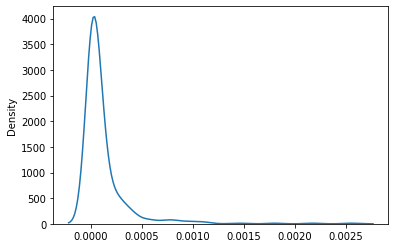

In [ ]:
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));

In [ ]:
sub = pd.read_csv('./gdrive/My Drive/Colab Notebooks/Семинар 10/data/sample_submission.csv')
sub['target'] = preds.cpu().numpy().reshape(-1,)
sub.to_csv('submission.csv', index=False)

ValueError: ignored